# **Predicting benefits nonclaimants in Canada with machine learning methods**

Ian Scott 

ECON 882: Research Problems and Methods

May 2, 2025

# **Introduction**
In the 2019 tax year, the Government of Canada transitioned the Workers Income Tax Benefit (WITB) to the Canadian Income Benefit (CIB). This benefit incentivizes workers to join the workforce by providing transfers for low-income Canadians who join the labour force. Students are not eligible for the benefit. The transition from WITB to CIB increased benefit payout and expanded eligibility. One key change was that tax filers were automatically assessed for qualifications under the CIB. The WITB had needed additional paperwork to apply for. Because of this, there was a large number of eligible non-claimants. I use publicly available income tax data from Statistics Canada to train several machine learning models to predict non-claimants and compare the results.


# **Question 1: Data**

I use the Canadian Income Survey (CIS) Public Use Microdata File (PUMF) for my analysis. I use the years 2012 to 2018, all available years of the dataset where the WITB was in effect. The CIS is an annual survey that collects additional information on individual and family income dynamics from a subset of Labour Force Survey respondents. It is the most detailed publicly available Canadian income dynamics dataset, making it the most suitable for my project. The CIS PUMF files I am using include 477,597 observations and 212 variables. Many variables are available at the individual, census family, and economic family levels. This could show how family dynamics could affect claimancy.

I identify those eligible for the WITB through their reported age groups, student status, and incomes. I use the annual range of WITB eligibility values to compute a binary variable which indicates eligibility. The WITB was only eligible to those 19+, but the age groups in my dataset include 18-year-olds in a group of those aged 18-24. Excluding the group with 18-year-olds would throw out observations of 19-24-year-olds, which would be costly. A majority of that age group is students, so I have limited concerns about the impact a small number of 18-year-olds will have on the overall validity of my results.

I identify WITB receivership through the "other government transfers" (OGOVTR) variable. This includes benefits other than the WITB, though most important transfers and benefits have their own specific variables. A non-claimant could foreseeably receive another benefit, not the WITB, and falsely be included in the non-claimant group. This is an issue with my data that cannot easily be remedied. Much as with the age variable, I have achieved as close an identification as possible. Calculating the exact WITB amount an observation is eligible for would be difficult with my dataset, so it was not attempted. I cut my sample down to those who are eligible for the WITB, which reduces the number of observations to 42,210. Several variables have swathes of NA values. I remove variables with NAs. This removes NAs while not sacrificing observations. This leaves me with 161 variables.


In [2]:
# Import data
data <- read.csv("882_data.csv")

# Loading Libraries
library(tidyverse)
library(rsample)
library(rpart)
library(Metrics)
library(mgcv)
library(xgboost)
library(randomForest)
library(tree)
library(splines)
library(grf)
library(leaps)
library(dplyr)
library(caret)
library(glmnet)
library(fastDummies)
library(rpart.plot)
library(pROC)

# Remove variables with missing values
data <- data[, colMeans(is.na(data)) == 0]


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The 

# **Question 2**

I randomly split the data into training and testing sets, using a seed for reproducibility. I split the data so that the training set is 70% of the data and the testing set is 30%. This provides my more complicated models with more training data while still having a large testing set. I am assuming some complexity in what makes someone not claim income tax benefits, so this also helps the models to identify more complex relationships.

In [3]:
### Splitting the data in to training and testing sets

# Set the seed for a random split
set.seed(123)

#Split the data into training and testing sets
df_split = initial_split(data = data, prop = 0.7)
df_train = training(df_split)
df_test = testing(df_split)

# **Question 3**

I detail my models used below. I am focused on classifying a binary variable, so I have selected methods suited to that task. I will compare them based on their ability to correctly classify claimants and non claimants. I place a higher weight on the ability of the model to avoid false negatives. One application of these models could be to decide who to notify about benefits they may be eligible for. In pursuit of that goal, notifying a false negative (someone who was already likely not to claim the benefits) would have little cost. However, it would be detrimental to get false positives (people who were going to claim benefits) since not sending them a notification would squander our goal of increasing the number of claimants. To compare models, I report their RMSE and the categories of their prediction (false negative, false positive, etc.). I also list sensitivity and specificity.

### **Linear Regression and Probit Regression**

I use linear regression and probit (logistic) models to provide a baseline for comparison with the other methods. Because of the complexity in relationships that could determine whether someone is a non-claimant, I do not expect these to perform well. These models are far more rigid than the machine learning models I will use. I run a single model with variables that explain geographic, income, and family dynamics. The intent is to capture a reasonable (but naive) baseline that the more advanced models can be compared to. I am not concerned about creating the absolute best of either of these models, since I will be using elastic net to create a better regression model.

### **Elastic Net**
I perform an elastic net to select and regularize variables. While I don’t have more variables than observations, I do have a large number of correlated variables. I want to select the variables to create the best regression model, but I use elastic net rather than ridge or LASSO regression because many of the variables in my dataset are correlated with each other. This includes the large selection of geographic variables, and the number of variables available at the individual, economic and census family levels.

I cross-validate my model to find the optimal tuning parameter (lambda) and use 100 folds. This will trade off bias and variance while fitting the model. This number of folds should give a significantly granular and accurate prediction to improve on the naive linear and logistic models. 

### **Random Forest and Probability Forest**
I use a random forest and probability forest (from the GRF package) models to classify claimants. These models can handle highly nonlinear relationships while also being more robust to overfitting than other models. They can capture interactions between variables better than the regression models I use.
These models are especially useful since some variables could interact in unpredictable ways. By bagging, the models stabilize their predictions.

The probability forest model is especially useful because it minimizes classification error, rather than squared error. However, it may be better at predicting probabilities than class labels. The probability model is tailored for probability accuracy rather than purely splitting observations. I will compare both models to see if there are performance differences.

I create a random forest model and cross-validate using 10-fold cross validation to determine the best performing models. I compare predictions using one, two, and three variables as a sample for splitting the nodes in my trees, and create 100 trees for each model.

### **Extreme Gradient Boosting**
Finally, I use an extreme gradient boosted model to predict non-claimants. This model is relatively computationally cheap to run. It combines a number of iteratively improved smaller trees to create more accurate results. It can be particularly good at working with cases that are harder to classify, thereby reducing overall error.
To compare models and optimize results, I use three specifications of extreme gradient boosted model:
- Default parameters,
- A lower learning rate with more trees,
- Deeper trees with fewer rounds

## **Results**

### **Naive OLS and Probit Models**

In [4]:
### Naive models

## Linear model
ols_model <- lm(nonrec ~ earng + efeipr + efinva + factor(mbmregp) + factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + factor(alfst) + factor(eftyp), data = df_train)

# Compute RMSE
resids <- residuals(ols_model)
rmse <- sqrt(mean(resids^2))
cat("The RMSE from the linear regression model is", rmse)

#Confusion matrix for probit model
ols_pred5 <- predict(ols_model,df_test)
ols_pred5 <- ifelse(ols_pred5 > 0.5,1,0)
confusionMatrix(as.factor(ols_pred5),as.factor(df_test$nonrec))

#Confusion matrix for probit model
ols_pred2 <- predict(ols_model,df_test)
ols_pred2 <- ifelse(ols_pred2 > 0.2,1,0)
confusionMatrix(as.factor(ols_pred2),as.factor(df_test$nonrec))

## Probit model
logit_model <- glm(nonrec ~ earng + efeipr + efinva + factor(mbmregp) + factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + factor(alfst) + factor(eftyp), data = df_train, family = "binomial")

# Compute RMSE
actual <- df_train$nonrec
pred_probs <- predict(logit_model, type = "response")
rmse <- sqrt(mean((pred_probs - actual)^2))

#Confusion matrix for probit model
glm_pred5 <- predict(logit_model,df_test)
glm_pred5 <- ifelse(glm_pred5 > 0.5,1,0)
confusionMatrix(as.factor(glm_pred5),as.factor(df_test$nonrec))

#Confusion matrix for probit model
glm_pred2 <- predict(logit_model,df_test)
glm_pred2 <- ifelse(glm_pred2 > 0.2,1,0)
confusionMatrix(as.factor(glm_pred2),as.factor(df_test$nonrec))

summary(ols_model)
summary(logit_model)

The RMSE from the linear regression model is 0.3897111

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1792  786
         1 1931 8155
                                          
               Accuracy : 0.7855          
                 95% CI : (0.7782, 0.7926)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4322          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4813          
            Specificity : 0.9121          
         Pos Pred Value : 0.6951          
         Neg Pred Value : 0.8085          
             Prevalence : 0.2940          
         Detection Rate : 0.1415          
   Detection Prevalence : 0.2036          
      Balanced Accuracy : 0.6967          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  309   87
         1 3414 8854
                                          
               Accuracy : 0.7235          
                 95% CI : (0.7157, 0.7313)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : 6.967e-06       
                                          
                  Kappa : 0.0991          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.08300         
            Specificity : 0.99027         
         Pos Pred Value : 0.78030         
         Neg Pred Value : 0.72172         
             Prevalence : 0.29398         
         Detection Rate : 0.02440         
   Detection Prevalence : 0.03127         
      Balanced Accuracy : 0.53663         
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2403 1446
         1 1320 7495
                                          
               Accuracy : 0.7816          
                 95% CI : (0.7743, 0.7888)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.479           
                                          
 Mcnemar's Test P-Value : 0.01747         
                                          
            Sensitivity : 0.6454          
            Specificity : 0.8383          
         Pos Pred Value : 0.6243          
         Neg Pred Value : 0.8503          
             Prevalence : 0.2940          
         Detection Rate : 0.1898          
   Detection Prevalence : 0.3039          
      Balanced Accuracy : 0.7419          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2088 1042
         1 1635 7899
                                          
               Accuracy : 0.7886          
                 95% CI : (0.7814, 0.7957)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.466           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5608          
            Specificity : 0.8835          
         Pos Pred Value : 0.6671          
         Neg Pred Value : 0.8285          
             Prevalence : 0.2940          
         Detection Rate : 0.1649          
   Detection Prevalence : 0.2472          
      Balanced Accuracy : 0.7221          
                                          
       'Positive' Class : 0               
                        


Call:
lm(formula = nonrec ~ earng + efeipr + efinva + factor(mbmregp) + 
    factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + 
    factor(alfst) + factor(eftyp), data = df_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2554 -0.2723  0.1008  0.2498  1.1055 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.422e-01  3.247e-02  13.619  < 2e-16 ***
earng             -1.312e-06  5.227e-07  -2.510 0.012076 *  
efeipr             1.050e-04  5.482e-06  19.160  < 2e-16 ***
efinva             7.331e-07  9.381e-08   7.815 5.67e-15 ***
factor(mbmregp)2  -5.648e-02  2.741e-02  -2.061 0.039312 *  
factor(mbmregp)3  -8.313e-02  2.378e-02  -3.496 0.000474 ***
factor(mbmregp)4   5.355e-03  2.343e-02   0.229 0.819256    
factor(mbmregp)5  -4.534e-02  2.173e-02  -2.086 0.036970 *  
factor(mbmregp)6  -5.847e-02  2.408e-02  -2.429 0.015164 *  
factor(mbmregp)7  -1.752e-01  2.223e-02  -7.883 3.30e-15 ***
factor(mbmregp)8  -1.3


Call:
glm(formula = nonrec ~ earng + efeipr + efinva + factor(mbmregp) + 
    factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + 
    factor(alfst) + factor(eftyp), family = "binomial", data = df_train)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -5.614e-01  2.560e-01  -2.194 0.028268 *  
earng             -8.565e-06  3.478e-06  -2.463 0.013792 *  
efeipr             6.428e-04  3.595e-05  17.879  < 2e-16 ***
efinva             7.273e-06  9.246e-07   7.866 3.67e-15 ***
factor(mbmregp)2  -5.678e-01  2.048e-01  -2.772 0.005569 ** 
factor(mbmregp)3  -7.827e-01  1.778e-01  -4.402 1.07e-05 ***
factor(mbmregp)4  -1.576e-01  1.780e-01  -0.886 0.375859    
factor(mbmregp)5  -4.509e-01  1.690e-01  -2.668 0.007627 ** 
factor(mbmregp)6  -6.149e-01  1.804e-01  -3.408 0.000654 ***
factor(mbmregp)7  -1.343e+00  1.616e-01  -8.314  < 2e-16 ***
factor(mbmregp)8  -1.104e+00  1.583e-01  -6.976 3.03e-12 ***
factor(mbmregp)9  -1.199e+00  1.7

The linear and probit models performed quite poorly. The models were also sensitive to the threshold probability used to classify predictions. The OLS model was particularly bad at predicting claimants. The probit model was better at this, but also worse at predicting non-claimants. OLS was only able to correctly identify true positives with a roughly 48% accuracy. While the logit model improved on that by 8%, that is still a relatively weak performance from both models.

The linear model was sensitive to the probability chosen to classify predictions (0.5 vs. 0.2) than the probit model. 

### **Dummying out categorical variables**

In [5]:
# List of categorical variables to be converted to dummies
categorical_vars <- c("prov", "uszgap", "mbmregp", "agegp", "sex", "marstp", "cmphi", 
                      "hlev2g", "studtfp", "fllprtp", "fworked", "scsum", "alfst", 
                      "wksem", "wksuem", "wksnlf", "fpdwk", "fsemp", "funfw", 
                      "immst", "yrimmg", "majri", "eftyp", "efmjieh", "efrmjig", 
                      "efagofmp", "efagyfmp", "hhcomp", "hhmj ie", "licofa", 
                      "licofb", "limsfa", "mbscf18", "dwltyp", "dwtenr", "repa", 
                      "suit", "mortg", "rnsub", "chneed", "fscadltm", "fscchldm", "fschhldm")

# Create dummies safely without model.matrix()
df_train2 <- fastDummies::dummy_cols(df_train, select_columns = categorical_vars, remove_first_dummy = FALSE, remove_selected_columns = TRUE)
df_test2  <- fastDummies::dummy_cols(df_test,  select_columns = categorical_vars, remove_first_dummy = FALSE, remove_selected_columns = TRUE)


Warning message in fastDummies::dummy_cols(df_train, select_columns = categorical_vars, :
"NOTE: The following select_columns input(s) is not a column in data.
	"
Warning message in fastDummies::dummy_cols(df_test, select_columns = categorical_vars, :
"NOTE: The following select_columns input(s) is not a column in data.
	"


## **Elastic Net**

In [6]:
### Elastic Net

# Split into dummied training and testing sets
X_train <- as.matrix(df_train2[, setdiff(names(df_train2), "nonrec")])
y_train <- df_train2$nonrec

X_test <- as.matrix(df_test2[, setdiff(names(df_test2), "nonrec")])
y_test <- df_test2$nonrec

# Fit Elastic Net (alpha = 0.5 for compromise between ridge and lasso)
# Note: R will automatically factor categorical variables and glmnet will automatically standardize predictors (see documentation)
cv_model <- cv.glmnet(X_train, y_train, family = "binomial", alpha = 0.5, nfolds = 100)

# Predict on test data using best lambda
pred_probs <- predict(cv_model, newx = X_test, type = "response", s = "lambda.min")

# Compute RMSE
rmse <- sqrt(mean((pred_probs - y_test)^2))
print(rmse)

In [ ]:
elastic_pred <- pred_probs
elastic_pred <- ifelse(elastic_pred > 0.5,1,0)
confusionMatrix(as.factor(elastic_pred),as.factor(df_test$nonrec))

ERROR: Error: object 'pred_probs' not found


Optimal lambda (lambda.min): 4.226521e-05 
Binomial deviance at lambda.min: 0.550793 
Largest lambda within 1SE of optimal lambda (lambda1se): 0.0001290719 
Binomial deviance at lambda1se: 0.5574794 


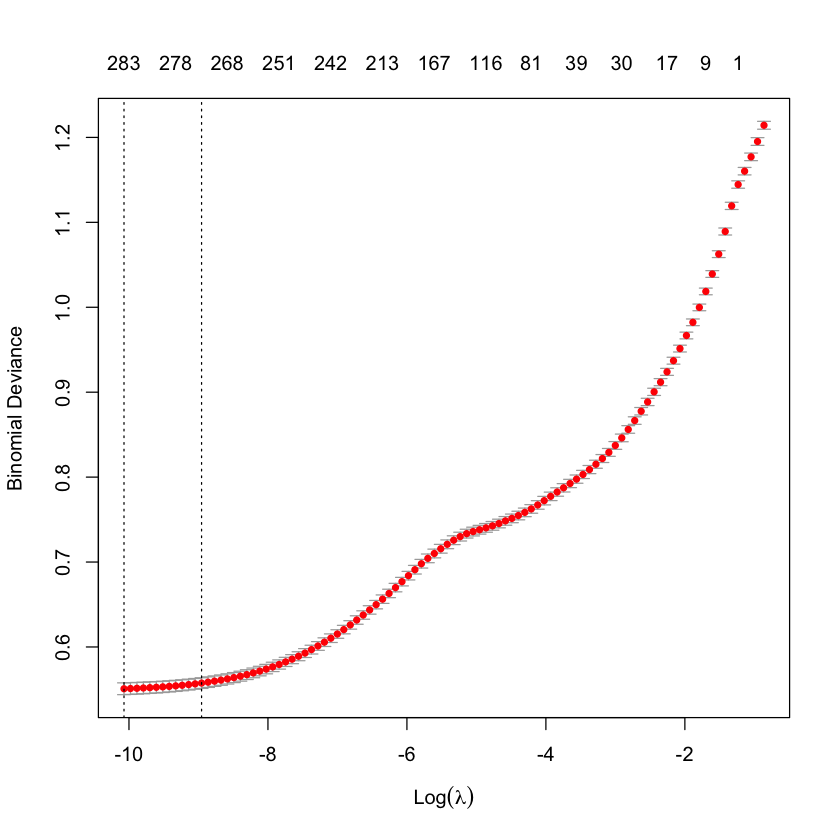

In [ ]:
#### Plots and lambda values for the elastic net model
lambda_opt <- cv_model$lambda.min
lambda1se <- cv_model$lambda.1se
lambda_min_index <- which(cv_model$lambda == lambda_opt)
lambda_1se_index <- which(cv_model$lambda == lambda1se)
binomial_dev_min <- cv_model$cvm[lambda_min_index]
binomial_dev_1se <- cv_model$cvm[lambda_1se_index]

# Print results
cat("Optimal lambda (lambda.min):", lambda_opt, "\n")
cat("Binomial deviance at lambda.min:", binomial_dev_min, "\n")
cat("Largest lambda within 1SE of optimal lambda (lambda1se):", lambda1se, "\n")
cat("Binomial deviance at lambda1se:", binomial_dev_1se, "\n")
lmin = cv_model$lambda.min
l1se = cv_model$lambda.1se
plot(cv_model)

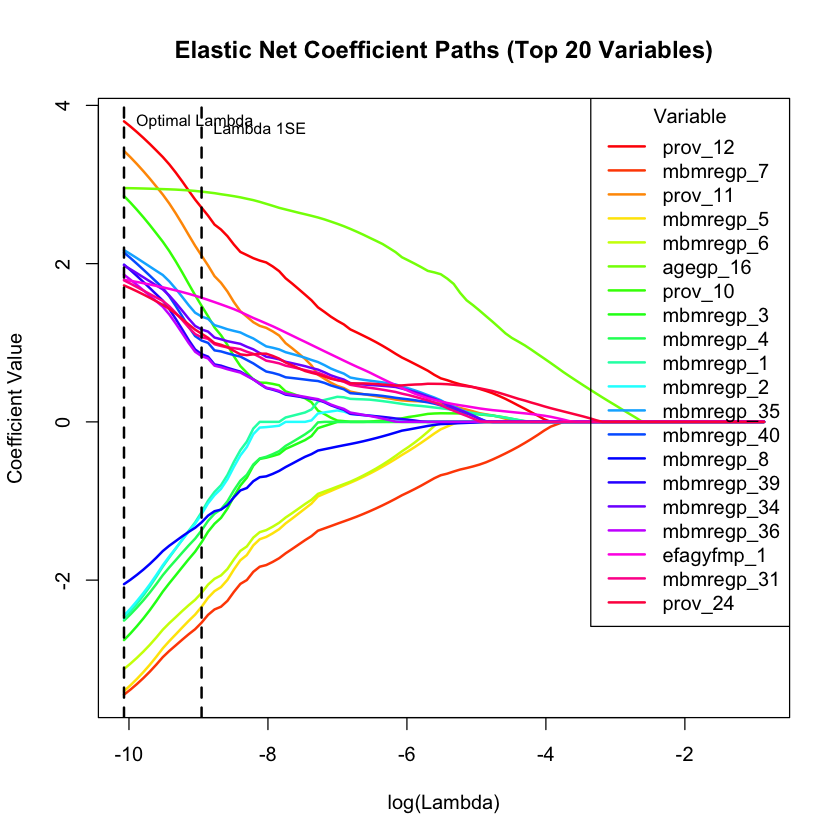

In [ ]:
# Extract coefficient matrix and lambda values
coef_matrix <- as.matrix(cv_model$glmnet.fit$beta)
lambda_vals <- cv_model$glmnet.fit$lambda

# Find coefficients at lambda.min
coef_at_lambda_min <- as.numeric(coef(cv_model, s = "lambda.min"))[-1] # drop intercept

# Select top 20 variables by absolute value
top20_indices <- order(abs(coef_at_lambda_min), decreasing = TRUE)[1:20]
top20_vars <- rownames(coef_matrix)[top20_indices]

# Assign colours
num_vars <- length(top20_vars)
colors <- rainbow(num_vars)

# Create the base plot
plot(log(lambda_vals), coef_matrix[top20_indices[1], ], type = "l",
     col = colors[1], lwd = 2, xlab = "log(Lambda)", ylab = "Coefficient Value",
     main = "Elastic Net Coefficient Paths (Top 20 Variables)",
     ylim = range(coef_matrix[top20_indices, ]),
     xlim = c(min(log(lambda_vals)), max(log(lambda_vals))))  

# Add remaining coefficient paths
for (i in 2:num_vars) {
  lines(log(lambda_vals), coef_matrix[top20_indices[i], ], col = colors[i], lwd = 2)
}

# Add a legend
legend("topright", legend = top20_vars, col = colors, lty = 1, lwd = 2, title = "Variable")

# Add vertical lines and annotations for optimal lambdas
abline(v = log(lmin), col = "black", lty = 2, lwd = 2)
text(log(lmin), max(coef_matrix[top20_indices, ]), labels = "Optimal Lambda", pos = 4, cex = 0.8, col = "black")

abline(v = log(l1se), col = "black", lty = 2, lwd = 2)
text(log(l1se), max(coef_matrix[top20_indices, ] - 0.1), labels = "Lambda 1SE", pos = 4, cex = 0.8, col = "black")


The elastic net model performed relatively well, but used a very low optimal lambda value. The coefficient paths for the 20 most important coefficients show that they were barely decreased. This suggests that the number of variables the model had access to was a more significant contributor to the predictions than the actual fitting the model performed.

The elastic net, however, had a large positive impact on the accuracy and sensitivity of the regression model. It had an accuracy more than 10% larger than either the OLS or probit models, and a more than 20% improvement in predicting true positives. The number of false non-claimants by the model is less than half that of the probit model. 

The coefficient paths for the 20 most important variables were almost entirely geographical. This reflects nonrandomness in the geography of non-claimants, but I expected more economic and social dynamics to come into play. Since many of the areas are in smaller provinces or more rural areas of larger provinces, they could relate to the availability of government resources in those areas.

## **Random Forest**

In [ ]:
### Random Forest

# 10-fold cross-validation
set.seed(123)
folds <- createFolds(y_train, k = 10)

# Grid of mtry values to try
mtry_grid <- 1:3
cv_results <- data.frame(mtry = mtry_grid, avg_accuracy = NA)

for (m in mtry_grid) {
  acc_folds <- c()
  
  for (fold in folds) {
    # Split data
    X_tr <- X_train[-fold, , drop = FALSE]
    y_tr <- y_train[-fold]
    X_val <- X_train[fold, , drop = FALSE]
    y_val <- y_train[fold]
    
    # Train random forest (classification)
    rf <- randomForest(x = X_tr, y = as.factor(y_tr), mtry = m, ntree = 100)
    
    # Predict on validation set
    preds <- predict(rf, X_val, type = "response")
    
    # Accuracy
    acc <- mean(preds == y_val)
    acc_folds <- c(acc_folds, acc)
  }
  
  # Store average accuracy
  cv_results$avg_accuracy[cv_results$mtry == m] <- mean(acc_folds)
}

# Show cross-validation results
print(cv_results)


In [ ]:
## Confusio matrix and variable importance chart

best_mtry <- cv_results$mtry[which.max(cv_results$avg_accuracy)]
cat("Best mtry:", best_mtry, "\n")

best_rf_model <- randomForest(x = X_train, y = as.factor(y_train), mtry = best_mtry, ntree = 100)



Best mtry: 3 


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2794  723
         1  929 8218
                                          
               Accuracy : 0.8696          
                 95% CI : (0.8636, 0.8754)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6806          
                                          
 Mcnemar's Test P-Value : 4.566e-07       
                                          
            Sensitivity : 0.7505          
            Specificity : 0.9191          
         Pos Pred Value : 0.7944          
         Neg Pred Value : 0.8984          
             Prevalence : 0.2940          
         Detection Rate : 0.2206          
   Detection Prevalence : 0.2777          
      Balanced Accuracy : 0.8348          
                                          
       'Positive' Class : 0               
                        

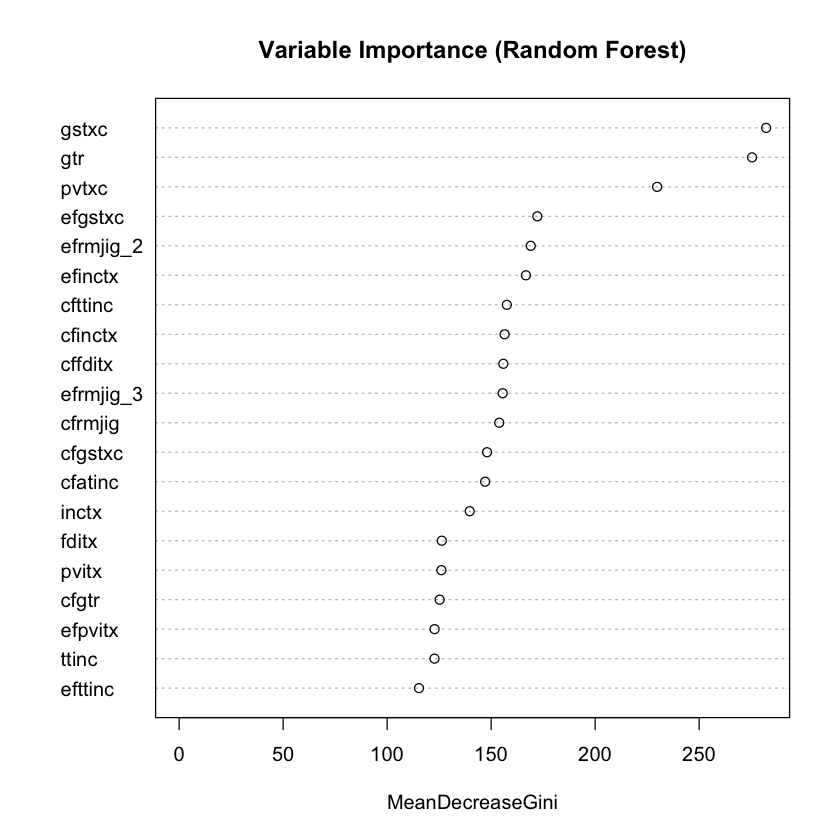

In [ ]:
rf_preds <- predict(best_rf_model, X_test, type = "response")
conf_matrix <- confusionMatrix(rf_preds, as.factor(y_test))
print(conf_matrix)

# Plot variable importance
varImpPlot(best_rf_model,
           type = 2,  # type = 2 for Mean Decrease Gini
           main = "Variable Importance (Random Forest)",
           n.var = 20)  # Show top 20 variables

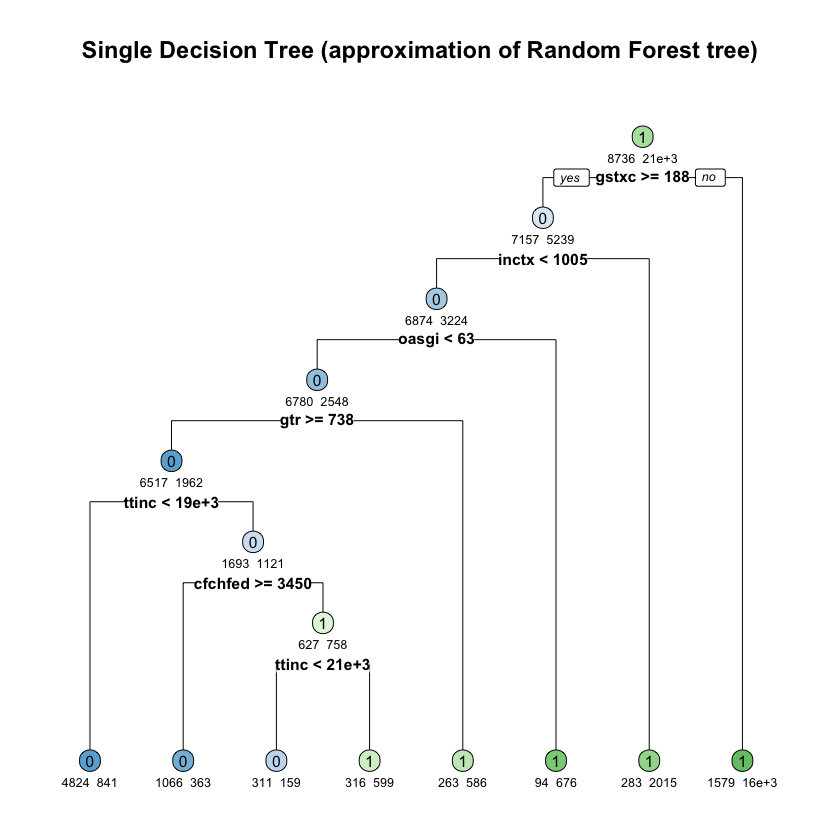

In [ ]:
single_tree <- rpart(as.factor(y_train) ~ ., data = as.data.frame(X_train))

# Plot the single tree
rpart.plot(single_tree,
           main = "Single Decision Tree (approximation of Random Forest tree)",
           type = 2,  # type 2 = labels all nodes
           extra = 1, # display probability of success
           under = TRUE,
           faclen = 0)

In [ ]:
 # Fit the probability forest (binary classification)
grf_model <- probability_forest(X_train, as.factor(y_train), mtry = best_mtry,␣
↪num.trees = 100)

# Predict probabilities
grf_probs <- predict(grf_model, newdata = X_test)

# Extract probability of class 1
prob_1 <- grf_probs$predictions[, 2]

# Turn into a dataframe
prob_df <- data.frame(probability_of_1 = prob_1)

# Convert to class labels
grf_preds <- ifelse(prob_df > 0.5, 1, 0)

# Evaluate performance
conf_matrix <- confusionMatrix(factor(grf_preds), factor(y_test))
print(conf_matrix)
importance_grf <- variable_importance(grf_model)
var_names <- colnames(X_train)

# Put into a dataframe
grf_importance_df <- data.frame(
Variable = var_names,
Importance = importance_grf
)

# Plot with ggplot2
library(ggplot2)
ggplot(grf_importance_df[order(-grf_importance_df$Importance), ][1:20, ],
aes(x = reorder(Variable, Importance), y = Importance)) +
geom_col(fill = "darkgreen") +
coord_flip() +
labs(title = "GRF Variable Importance", x = "Variable", y = "Importance") +
theme_minimal()

The random forest and probability forests both performed poorly relative to elastic net and extreme gradient boosting. The probability forest performed much worse than random forest, suggesting that classification through probabilities was indeed less efficient.

The approximate decision tree for the random forest model includes several variables, most of which have to do with income and tax values. The thresholds suggest some relation to the proximity to claimancy being a determining factor. This is consistent with economic theory, since those who have smaller marginal benefits from claiming the WITB would be less likely to fill out the complicated paperwork which is necessary.

## **Extreme Gradient Boosting**

In [ ]:
### XGBoost

# Convert data to XGBoost DMatrix format
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest  <- xgb.DMatrix(data = X_test, label = y_test)

# Model 1: Default Parameters
xgb_model1 <- xgboost(
  data = dtrain,
  nrounds = 100,
  max_depth = 3,
  eta = 0.1,
  subsample = 1,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Model 2: Lower Learning Rate, More Trees
xgb_model2 <- xgboost(
  data = dtrain,
  nrounds = 500,
  max_depth = 4,
  eta = 0.05,
  subsample = 0.8,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Model 3: Deeper Trees, Fewer Rounds
xgb_model3 <- xgboost(
  data = dtrain,
  nrounds = 200,
  max_depth = 6,
  eta = 0.1,
  subsample = 0.7,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Make predictions on the test sample (probabilities)
pred_xgb1 <- predict(xgb_model1, dtest)
pred_xgb2 <- predict(xgb_model2, dtest)
pred_xgb3 <- predict(xgb_model3, dtest)

# If you want to predict 0/1 classes (not probabilities), threshold at 0.5
pred_class_xgb1 <- ifelse(pred_xgb1 > 0.5, 1, 0)
pred_class_xgb2 <- ifelse(pred_xgb2 > 0.5, 1, 0)
pred_class_xgb3 <- ifelse(pred_xgb3 > 0.5, 1, 0)

# Compute RMSE for Each Model
rmse_xgb1 <- sqrt(mean((pred_xgb1 - y_test)^2))
rmse_xgb2 <- sqrt(mean((pred_xgb2 - y_test)^2))
rmse_xgb3 <- sqrt(mean((pred_xgb3 - y_test)^2))

cat("Test RMSE for XGBoost Model 1 (Default Parameters):", rmse_xgb1, "\n")
cat("Test RMSE for XGBoost Model 2 (Lower Learning Rate, More Trees):", rmse_xgb2, "\n")
cat("Test RMSE for XGBoost Model 3 (Deeper Trees, Fewer Rounds):", rmse_xgb3, "\n")

## Create XGBoost confusion matrix

# Create a named vector of RMSEs
rmse_values <- c(
  Model1 = rmse_xgb1,
  Model2 = rmse_xgb2,
  Model3 = rmse_xgb3
)

# Find the best model (lowest RMSE)
best_model_name <- names(rmse_values)[which.min(rmse_values)]
best_rmse_value <- min(rmse_values)

# Print the best model
cat("Best XGBoost Model:", best_model_name, "with RMSE:", round(best_rmse_value, 4), "\n")

# Map the model name to the actual model object
best_xgb_model <- switch(
  best_model_name,
  Model1 = xgb_model1,
  Model2 = xgb_model2,
  Model3 = xgb_model3
)

# Predict probabilities
xgb_probs <- predict(best_xgb_model, newdata = dtest)

# Convert to class labels
xgb_preds <- ifelse(xgb_probs > 0.5, 1, 0)

# Confusion Matrix
conf_matrix_xgb <- confusionMatrix(factor(xgb_preds), factor(y_test))
print(conf_matrix_xgb)


The best-performing extreme gradient boosting model was model 3, which used deeper trees and fewer rounds. The model had a very good RMSE value, and seems to perform incredibly well on more extreme probabilities (Figure 1). The model has a very large number of false nonclaimants relative to the number of false claimants. This ratio is also large compared to other models. While this reflects a lower cost for my theoretical policy objective (as outlined before), it could be a concern depending on the purpose of the model. 

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


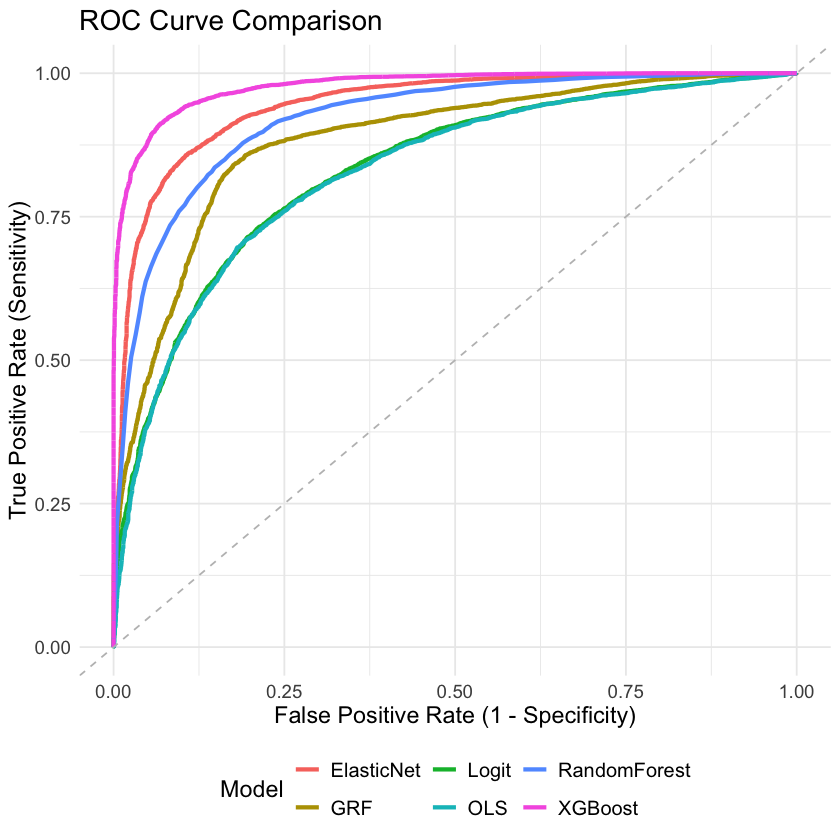

In [ ]:
### Plot ROC

# Generate Probabilities for Each Model
logit_probs <- predict(logit_model, newdata = df_test, type = "response")
ols_probs <- predict(ols_model, newdata = df_test)
elastic_net_probs <- predict(cv_model, newx = X_test, type = "response", s = "lambda.min")
rf_probs <- predict(best_rf_model, newdata = X_test, type = "prob")[,2]
xgb_probs <- predict(best_xgb_model, newdata = dtest)  

# True labels
Y_test <- y_test

# Create ROC objects
roc_list <- list(
  Logit = roc(Y_test, logit_probs),
  OLS = roc(Y_test, ols_probs),
  ElasticNet = roc(Y_test, as.vector(elastic_net_probs)),
  RandomForest = roc(Y_test, rf_probs),
  XGBoost = roc(Y_test, xgb_probs),
  GRF = roc(Y_test, prob_1)
)

# Extract ROC data
roc_data <- do.call(rbind, lapply(names(roc_list), function(model_name) {
  roc_curve <- roc_list[[model_name]]
  data.frame(
    model = model_name,
    specificity = rev(roc_curve$specificities),
    sensitivity = rev(roc_curve$sensitivities)
  )
}))

# Plot ROC curves
ggplot(roc_data, aes(x = 1 - specificity, y = sensitivity, color = model)) +
  geom_line(size = 1.2) +
  geom_abline(linetype = "dashed", color = "gray") +
  labs(
    title = "ROC Curve Comparison",
    x = "False Positive Rate (1 - Specificity)",
    y = "True Positive Rate (Sensitivity)",
    color = "Model"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 14),
    legend.position = "bottom",
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )


### **Extreme Gradient Boosting**

The best-performing extreme gradient boosting model was model 3, which used deeper trees and fewer rounds. The model had a very good RMSE value, and seems to perform incredibly well on more extreme probabilities (Figure 1). The model has a very large number of false nonclaimants relative to the number of false claimants. This ratio is also large compared to other models. While this reflects a lower cost for my theoretical policy objective (as outlined before), it could be a concern depending on the purpose of the model. 

### **Random Forest and Probability Forest**

The random forest and probability forests both performed poorly relative to elastic net and extreme gradient boosting. The probability forest performed much worse than random forest, suggesting that classification through probabilities was indeed less efficient.

The approximate decision tree for the random forest model includes several variables, most of which have to do with income and tax values. The thresholds suggest some relation to the proximity to claimancy being a determining factor. This is consistent with economic theory, since those who have smaller marginal benefits from claiming the WITB would be less likely to fill out the complicated paperwork which is necessary.

### **Overall Results**

XGBoost performed the best, followed by elastic net. While random and probability forests performed better than either naive regression model, they failed to fit the data well. These results are visible on the ROC curve chart.

XGBoost had, by far, the smallest number of false non-claimants (Table 1). The next closest performing model, elastic net, had nearly one and a half times the number of false positives as the boosted model. GRF performed worse with regard to false positives than the logit model, but better than the linear regression model. Overall, I am disappointed by the results of the random forest and probability forest models.

I demonstrate the use of machine learning models to predict benefit non-claimancy using tax data. My best-performing model has a 92.8% accuracy, which outperforms my worst model with a 78.2% accuracy and a larger degree of sensitivity. My results have surprisingly low performance from random forest-based methods. Further research could seek more accurate results or attempt to address issues by more accurately determining the non-claimant group.

## **Question 4**

Question 3 showed me the importance of comparing models and classifying using appropriately calculated probabilities. The best example is the random forest vs. probability forest. I would assume the probability forest would perform better because I had initially associated probabilities with giving a better picture of classification. This wasn’t true, and the probability forest performed poorly. Going through question 3 also confirmed the power of extreme gradient boosting to me.

Given more time and access to more data, I would have liked to compare results with the Longitudinal Administrative Database (LAD). It would have been interesting to see how well the models worked if there were individuals who sometimes did and sometimes did not claim the WITB. It would be interesting to measure the impact of the CWB’s automatic enrollment on labour supply and quality of life variables on WITB non-claimants. This could be further augmented by using machine learning methods to identify newly eligible claimants who likely would not have claimed under the WITB. This would support policy analysis and offer additional insights not possible with existing LAD data.
